# TF2로 Matrix Factorization을 SGD를 통해 구현한다. 

* Matrix Factorization 
  * A(n_row, n_col) ~=  P(n_row, emb_sz) * Q(emb_sz, n_col1)

In [1]:
import numpy as np
import tensorflow as tf

In [10]:
class MatrixFactorizationLayer(tf.keras.layers.Layer):
    
    def __init__(self, emb_sz, **kwargs):
        super(MatrixFactorizationLayer, self).__init__(**kwargs)
        self.emb_sz = emb_sz
        
    def build(self, input_shape):
        num_rows, num_cols = input_shape
        self.P = self.add_variable("P",
            shape=[num_rows, self.emb_sz],
            dtype=tf.float32,
            initializer=tf.initializers.GlorotUniform)
                
        self.Q = self.add_variable("Q",
            shape=[num_cols, self.emb_sz],
            dtype=tf.float32,
            initializer=tf.initializers.GlorotUniform)
        
    def call(self, input):
        # weight들의 곱으로만 approx가 되어야 하므로 입력은 의미가 없다.
        
        return tf.matmul(self.P, tf.transpose(self.Q))

class MatrixFactorizationModel(tf.keras.Model):
    def __init__(self, emb_sz):
        super(MatrixFactorizationModel, self).__init__()
        self.mfl = MatrixFactorizationLayer(emb_sz)
        self.sigmoid = tf.keras.layers.Activation("sigmoid")        
        
    def call(self, x):
        x = self.mfl(x)
        x = self.sigmoid(x)
        return x

Model: "matrix_factorization_model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
matrix_factorization_layer_5 multiple                  3000      
_________________________________________________________________
activation_5 (Activation)    multiple                  0         
Total params: 3,000
Trainable params: 3,000
Non-trainable params: 0
_________________________________________________________________


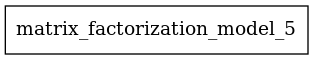

In [21]:
EMBEDDING_SIZE = 20
NUM_ROWS = 50
NUM_COLS = 100

# this is the input matrix R, which we are currently spoofing
# with a random matrix (this should be sparse)
R = np.random.random((NUM_ROWS, NUM_COLS))

model = MatrixFactorizationModel(EMBEDDING_SIZE)
model.build(input_shape=R.shape)
model.summary()
tf.keras.utils.plot_model(model, show_shapes=True)

In [22]:
# train model

def loss_fn(source, target):
    mse = tf.keras.losses.MeanSquaredError()
    loss = mse(source, target)
    return loss   

optimizer = tf.optimizers.RMSprop(learning_rate=1e-3, momentum=0.9)
losses, steps = [], []
for i in range(10000):
    with tf.GradientTape() as tape:
        Rprime = model(R)
        loss = loss_fn(R, Rprime)
        if i % 1000 == 0:
            loss_value = loss.numpy()
            losses.append(loss_value)
            steps.append(i)
            print("step: {:d}, loss: {:.3f}".format(i, loss_value))
    variables = model.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

step: 0, loss: 0.083
step: 1000, loss: 0.022
step: 2000, loss: 0.020
step: 3000, loss: 0.019
step: 4000, loss: 0.018
step: 5000, loss: 0.018
step: 6000, loss: 0.018
step: 7000, loss: 0.017
step: 8000, loss: 0.017
step: 9000, loss: 0.017


In [23]:
# after training, retrieve P and Q
mf_layer = model.layers[0]
P, Q = [weight.numpy() for weight in mf_layer.weights]
print(P.shape, Q.shape)

(50, 20) (100, 20)
